# District heating system Dispatch optimization
#### Including 
- CO2 limit to heat emission factor of 180 g/kWh
- emission constraint
- Dispatch Optimization with min and max modulation


## 1) Import required libraries and input data, set boundary conditions

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as po
import seaborn as sns

# here we import the oemof libraries
from oemof import solph
from oemof.solph import constraints

In [2]:
# read data from input csv file into Pandas DataFrame

full_filename = os.path.join('heat_profile_exam_project (1).csv')
input_data = pd.read_csv(full_filename,index_col = 'timestamp')
input_data.index=pd.to_datetime(input_data.index,utc=True)
input_data

,pth_load,price_el,pv_load,Temp
timestamp,,,,
2017-12-31 23:00:00+00:00,0.304666,-5.27,0.0,8.31
2018-01-01 00:00:00+00:00,0.323858,-29.99,0.0,7.85
2018-01-01 01:00:00+00:00,0.310962,-56.65,0.0,7.34
2018-01-01 02:00:00+00:00,0.319773,-63.14,0.0,6.69
2018-01-01 03:00:00+00:00,0.274180,-64.62,0.0,6.27
...,...,...,...,...
2018-12-31 18:00:00+00:00,0.520880,58.28,0.0,3.88
2018-12-31 19:00:00+00:00,0.520796,50.01,0.0,3.70
2018-12-31 20:00:00+00:00,0.462257,45.06,0.0,3.26


In [3]:
input_data.index.freq = 'H'

In [4]:
# set boundary conditions
pth_load = 5000  # max. heat load in kW
Qth_store = 6939.12 # capacity of heat storage in kWh
price_ngas = 100   # gas price in €/MWh
price_grid = 400 # grid costs in €/MWh
price_feedin = 120 # feed in costs in €/MWh
price_gh2 = 174.01 #feed in costs in €/MWh

eta_boiler = 0.93 # efficiency of the boiler 

eta_el_CHP = 0.43 # electrical efficiency of CHP unit
sigma_CHP = 0.98 # power-to-heat ratio CHP

In [5]:
#CO2_limit of the system is defined
Total_yearly_demand = input_data['pth_load'].sum()
Peak_load = pth_load 
Heat_demand = Total_yearly_demand * Peak_load
CO2_heat_limit = 180 #unit in g/kWh
CO2_limit =(Heat_demand*CO2_heat_limit)/1000 # units in kg
print("Total Heat in year (kWh/kW):",Total_yearly_demand)
print("Total energy demand (kWh):", Heat_demand)
print('CO2_limit(Kg):',CO2_limit)

Total Heat in year (kWh/kW): 2032.6904147
Total energy demand (kWh): 10163452.0735
CO2_limit(Kg): 1829421.37323


In [6]:
# define emission factors and CO2 limit
fCO2_el = 400 # unit g/kWh
fCO2_ngas = 240 # unit g/kWh
fCO2_H2 = 0 #unit in g/kwh
fCO2_heat = 180 #unit g/kWh
fCO2_feedin = -400 #unit g/kWh
fCO2_PV = 0 #unit g/kWh
# define share of heat pump with regard to the total heat production
hp_tshare = 0.3

In [7]:
#Assumed data for dispatch optimisation
pth_boiler = 3210 #unit in kW
pth_HP = 691 #unit in kW
pth_CHP = 1020 #unit in kW
pel_CHP = 1000 #unit in kW
pel_PV = 250 #unit in kW

## 2) Create energy system, define buses, sources, sinks and transformers
### 2.1) Create energy system

In [8]:
# create an energy system
es = solph.EnergySystem(timeindex=input_data.index)

### 2.2) Define buses

In [9]:
# natural gas bus
bngas = solph.Bus(label='ngbus')

# electricity bus
bel = solph.Bus(label='ebus')

# thermal bus
bth = solph.Bus(label='tbus')

# feed in bus
bfdin = solph.Bus(label='fdinbus')

# PV bus
bpv = solph.Bus(label='PVbus')

### 2.3) Define sources and sinks

In [10]:
# natural gas supply from public grid
supply_ngas = solph.Source(label='supply_ngas',
                           outputs={bngas: solph.Flow(variable_costs=price_ngas/1000,
                                                     emission_factor=fCO2_ngas/1000)}) 

# Electricity supply from the grid
supply_el = solph.Source(label='public_grid',
                       outputs={bel: solph.Flow(variable_costs=((input_data['price_el']+price_grid)/1000),
                                               emission_factor=fCO2_el/1000)})
#pv
supply_PV = solph.Source(label='PV',
                        outputs={bpv:solph.Flow(fix=input_data['pv_load'],
                                                pv_nominal_value = pel_PV,
                                               emission_factor=fCO2_PV/1000)})
# heat demand
heat_demand = solph.Sink(label='tload',
                         inputs={bth: solph.Flow(fix=input_data['pth_load'],
                                                 nominal_value=pth_load)})

#feed_in
Feed_in_CHP = solph.Sink(label='CHP feed in',
                        inputs={bfdin:solph.Flow(variable_costs=((input_data['price_el']+price_feedin)/1000),
                                                emission_factors= fCO2_feedin/1000)})

In [11]:
# COP submodel
COP_max=3 #highest COP at Higher temperature
COP_min=2.5 #Lowest COP at Lowest temperature
lowest_temp = input_data['Temp'].min() #Lowest temperature in the year 
highest_temp = input_data['Temp'].max() #Highest temperature in the year
M =((COP_max - COP_min)/(highest_temp-lowest_temp))
B =(COP_min -(M*lowest_temp))
COP =(M * np.array(input_data['Temp']))+B #quadratic equation for the submodel of temperature dependent COP of Heat Pump
print("Lowest ambient Temperature :", lowest_temp)
print("Highest ambient Temperature :", highest_temp)
print(COP)

Lowest ambient Temperature : -18.63
Highest ambient Temperature : 31.43
[2.76907711 2.76448262 2.75938873 ... 2.71863763 2.71624051 2.71664003]


### 2.4) Define transformers and storages
#### Here we include : 
- Here we include:
- min and max power values for our transformers (limits for modulation)
- By adding a nonconvex flow we can define min up and downtimes in order to avoid frequent start/stop cycles.

In [12]:
# heat pump with min/max limits for modulation and min up/downtimes (nonconvex flow). The initial status is "on".

heatPump = solph.Transformer(label='heat_pump',
                           inputs={bel: solph.Flow()},
                           outputs={bth: solph.Flow(nominal_value=pth_HP,
                                                    min=0.5,
                                                    max=1.0,
                                                    nonconvex=solph.NonConvex(),
                                                    T_output_flow=True)},
                           conversion_factors={bth:COP})

# boiler 
boiler = solph.Transformer(label='boiler',
                           inputs={bngas: solph.Flow()},
                           outputs={bth: solph.Flow(nominal_value=pth_boiler,
                                                    min=0.3,
                                                    max=1.0,
                                                    nonconvex=solph.NonConvex(),
                                                   T_output_flow=True)},
                           conversion_factors={bngas: 1/eta_boiler})

# motoric CHP
mCHP = solph.Transformer(label='mCHP',
                         inputs={bngas: solph.Flow()},
                         outputs={bfdin: solph.Flow(nominal_value=pel_CHP,
                                                   min=0.5,
                                                    max=1.0,
                                                    nonconvex=solph.NonConvex()),
                                  bth: solph.Flow(T_output_flow=True)},
                         conversion_factors={bngas: 1/eta_el_CHP,
                                             bth: 1/sigma_CHP})
#pv
tPV = solph.Transformer(label='tPV',
                       inputs={bpv: solph.Flow()},
                       outputs={bel:solph.Flow(nominal_value=pel_PV)},
                       conversion_factors={bel:1})

In [13]:
# thermal storage
therm_store = solph.components.GenericStorage(label='storage_thermal',
                                              nominal_storage_capacity=Qth_store,
                                              inputs={bth: solph.Flow()},
                                              outputs={bth: solph.Flow()},
                                              initial_storage_level=0.5,
                                              balanced=True,
                                              )

### 2.5) Add buses, sources, sinks and transformers to the energy system

In [14]:
# add buses to energy system
es.add(bngas, bel, bth, bfdin, bpv)

# add sources and sinks to energy system
es.add(supply_ngas, supply_el, supply_PV, Feed_in_CHP, heat_demand)

# add transformers to energysystem
es.add(heatPump, mCHP, boiler, therm_store,tPV)

## 3) Build and solve model

### 3.1) Build model

In [15]:
# create model
om = solph.Model(es)

### 3.2) Add constraints

In [16]:
# create pyomo block for defining constraints.
# the "constr_block" will contain the flows and expressions to be considered for the contraint definitions
constr_block = po.Block()

In [17]:
# create list with flows for emission constraint -> search for all flows including the attribute "emission_factor"
constr_block.INPUTFLOWS = [k for (k, v) in om.flows.items()
                           if hasattr(v, 'emission_factor')]
constr_block.INPUTFLOWS

[("<oemof.solph.network.source.Source: 'supply_ngas'>",
  "<oemof.solph.network.bus.Bus: 'ngbus'>"),
 ("<oemof.solph.network.source.Source: 'public_grid'>",
  "<oemof.solph.network.bus.Bus: 'ebus'>"),
 ("<oemof.solph.network.source.Source: 'PV'>",
  "<oemof.solph.network.bus.Bus: 'PVbus'>")]

In [18]:
# create list with flows for thermal share -> search for all flows including the attribute "T_output_flow"
constr_block.TFLOWS = [k for (k,v) in om.flows.items()
                       if hasattr(v, 'T_output_flow')]
constr_block.TFLOWS

[("<oemof.solph.network.transformer.Transformer: 'heat_pump'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>"),
 ("<oemof.solph.network.transformer.Transformer: 'mCHP'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>"),
 ("<oemof.solph.network.transformer.Transformer: 'boiler'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>")]

In [19]:
# add the constraints sub-model to the oemof model instance
om.add_component('Constr_Block', constr_block)

In [20]:
# add emission constraint to the constraint block
constr_block.emission_constr = po.Constraint(expr=
                                             (sum(om.flow[i, o, t]*om.flows[i, o].emission_factor 
                                                  for (i, o) in constr_block.INPUTFLOWS
                                                   for t in om.TIMESTEPS) 
                                              <= CO2_limit))

In [21]:
# emission constraint for heat
heat_constr = po.Constraint(expr=
                           (sum(om.flow[i, o, t] * om.flows[i, o].emission_factor 
                                for (i, o) in constr_block.INPUTFLOWS 
                                for t in om.TIMESTEPS 
                                if om.flows[i, o].emission_factor == fCO2_heat) 
                                <= fCO2_heat))

In [22]:
# add thermal share constraint to the constraint block
constr_block.tshare_constr = po.Constraint(expr=
                                            (sum(om.flow[heatPump, bth, t]
                                                 for t in om.TIMESTEPS)
                                             >= hp_tshare * sum(om.flow[i, o, t]
                                                                for (i, o) in constr_block.TFLOWS
                                                                for t in om.TIMESTEPS))) 

### 3.3) Solve model

In [23]:
om.solve(solver='cbc', solve_kwargs={'tee': False})

{'Problem': [{'Name': 'unknown', 'Lower bound': 591549.42051634, 'Upper bound': 591549.42051634, 'Number of objectives': 1, 'Number of constraints': 78827, 'Number of variables': 87575, 'Number of binary variables': 26280, 'Number of integer variables': 26280, 'Number of nonzeros': 26280, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 3300.37, 'Wallclock time': 3300.37, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 3830, 'Number of created subproblems': 3830}, 'Black box': {'Number of iterations': 510045}}, 'Error rc': 0, 'Time': 3300.6351249217987}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## 4) Retrieve and visualize results

In [24]:
# retrieve results
results = solph.processing.results(om)
res_bth = solph.views.node(results,'tbus')['sequences']
res_bngas = solph.views.node(results,'ngbus')['sequences']
res_bel = solph.views.node(results,'ebus')['sequences']
res_fbdin = solph.views.node(results,'fdinbus')['sequences']
res_hp = solph.views.node(results,'heat_pump')['sequences']
res_boiler = solph.views.node(results,'boiler')['sequences']
res_chp = solph.views.node(results,'mCHP')['sequences']
res_pv = solph.views.node(results,'tPV')['sequences']

In [38]:
# determine share of heat pump
hp_t_output = res_bth[(('heat_pump', 'tbus'), 'flow')].sum()
boiler_t_output = res_bth[(('boiler', 'tbus'), 'flow')].sum()
CHP_t_output = res_bth[(('mCHP','tbus'),'flow')].sum()
hp_tshare_res = hp_t_output / (hp_t_output + boiler_t_output+CHP_t_output)
boiler_t_output_res = boiler_t_output / (hp_t_output + boiler_t_output+CHP_t_output)
CHP_t_output_res = CHP_t_output / (hp_t_output + boiler_t_output+CHP_t_output)
print("Thermal share of the heat pump: {:.1f} %".format(hp_tshare_res*100))
print("Thermal share of the Boiler: {:.1f} %".format(boiler_t_output_res*100))
print("Thermal share of the CHP: {:.1f} %".format(CHP_t_output_res*100))

Thermal share of the heat pump: 45.9 %
Thermal share of the Boiler: 54.1 %
Thermal share of the CHP: 0.0 %


In [26]:
# print total cost and total CO2
print('Total cost {:.2f} €'.format(om.objective()))
print('Total CO2 {:.2f} kg'.format(constr_block.emission_constr()))

Total cost 591549.42 €
Total CO2 1419718.61 kg


[Text(0, 0.5, 'Thermal Power in kW')]

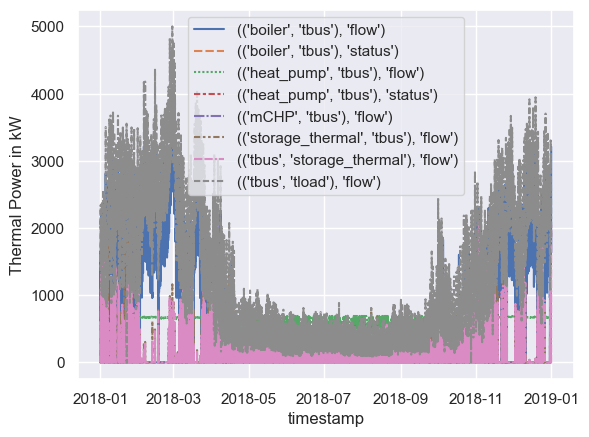

In [27]:
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bth, drawstyle='steps-post')
plot.set(ylabel='Thermal Power in kW')

[Text(0, 0.5, 'Fuel Power in kW')]

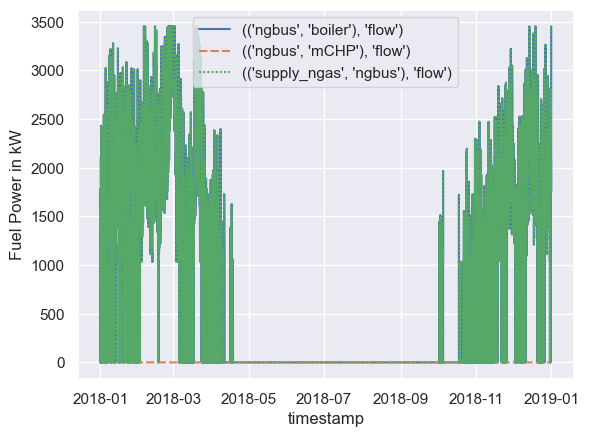

In [28]:
plot = sns.lineplot(data=res_bngas, drawstyle='steps-post')
plot.set(ylabel='Fuel Power in kW')

[Text(0, 0.5, 'Electric Power in kW')]

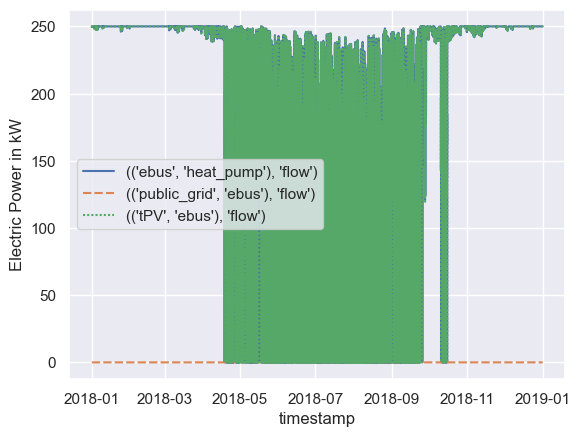

In [29]:
plot = sns.lineplot(data=res_bel, drawstyle='steps-post')
plot.set(ylabel='Electric Power in kW')

[Text(0, 0.5, 'Electric power in kw')]

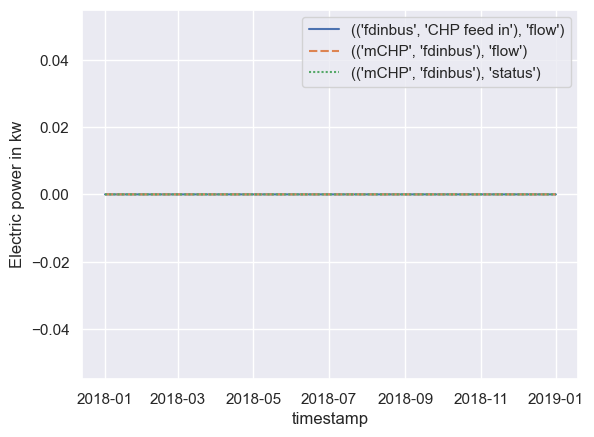

In [30]:
plot =sns.lineplot(data=res_fbdin, drawstyle='steps-post')
plot.set(ylabel='Electric power in kw')

[Text(0, 0.5, 'Electric Power in kW')]

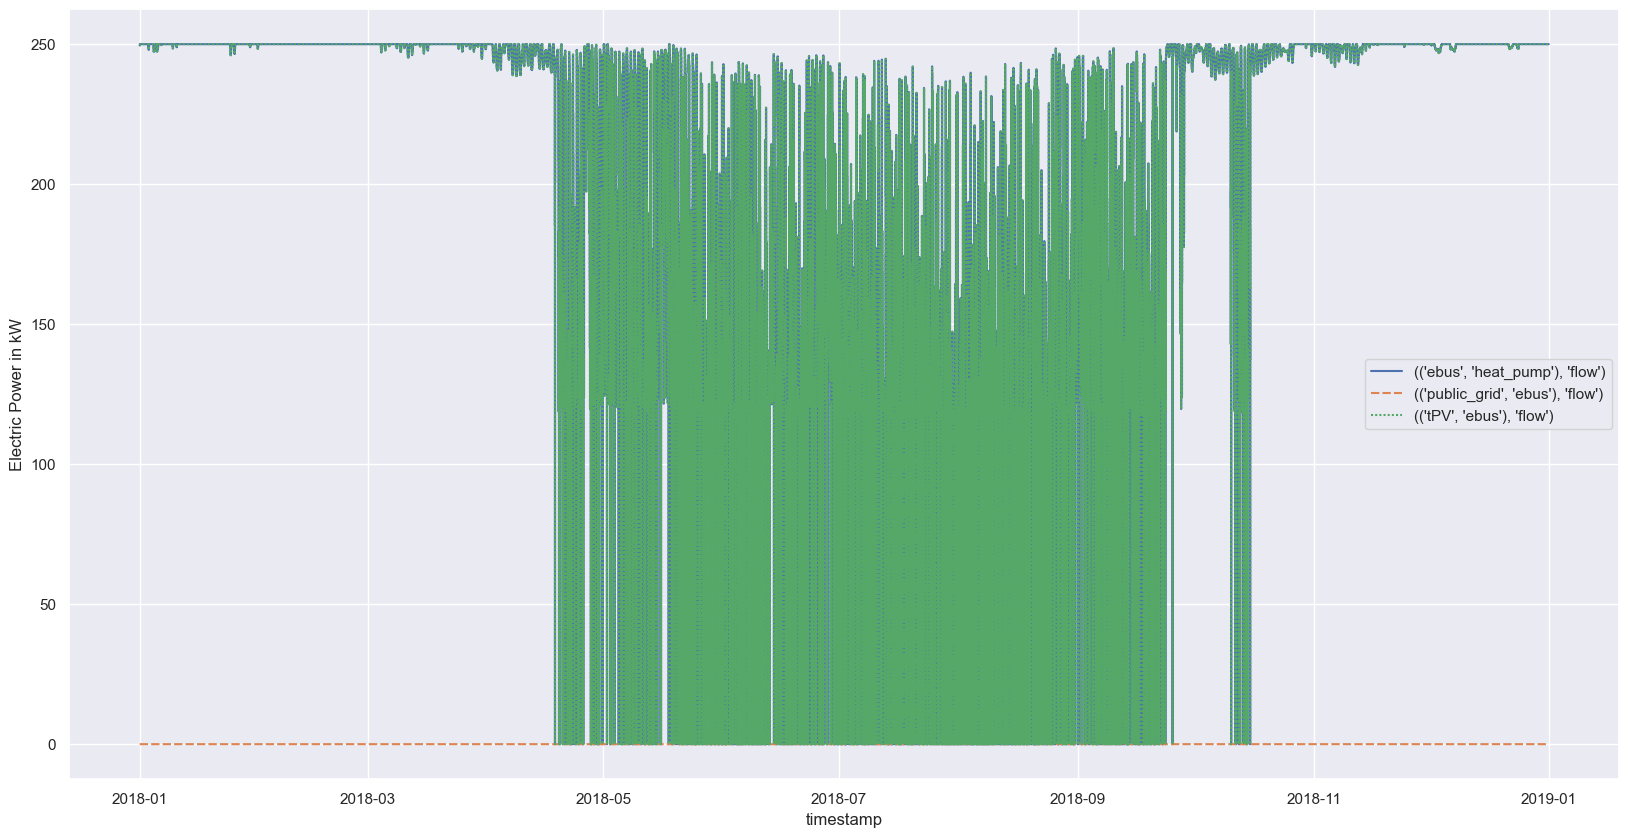

In [31]:
plt.figure(figsize=(20,10))
profiles = solph.processing.results(om)
res_bel = solph.views.node(profiles,'ebus')['sequences']
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bel, drawstyle='steps-post')
plot.set(ylabel='Electric Power in kW')

[Text(0, 0.5, 'Electric Power in kW')]

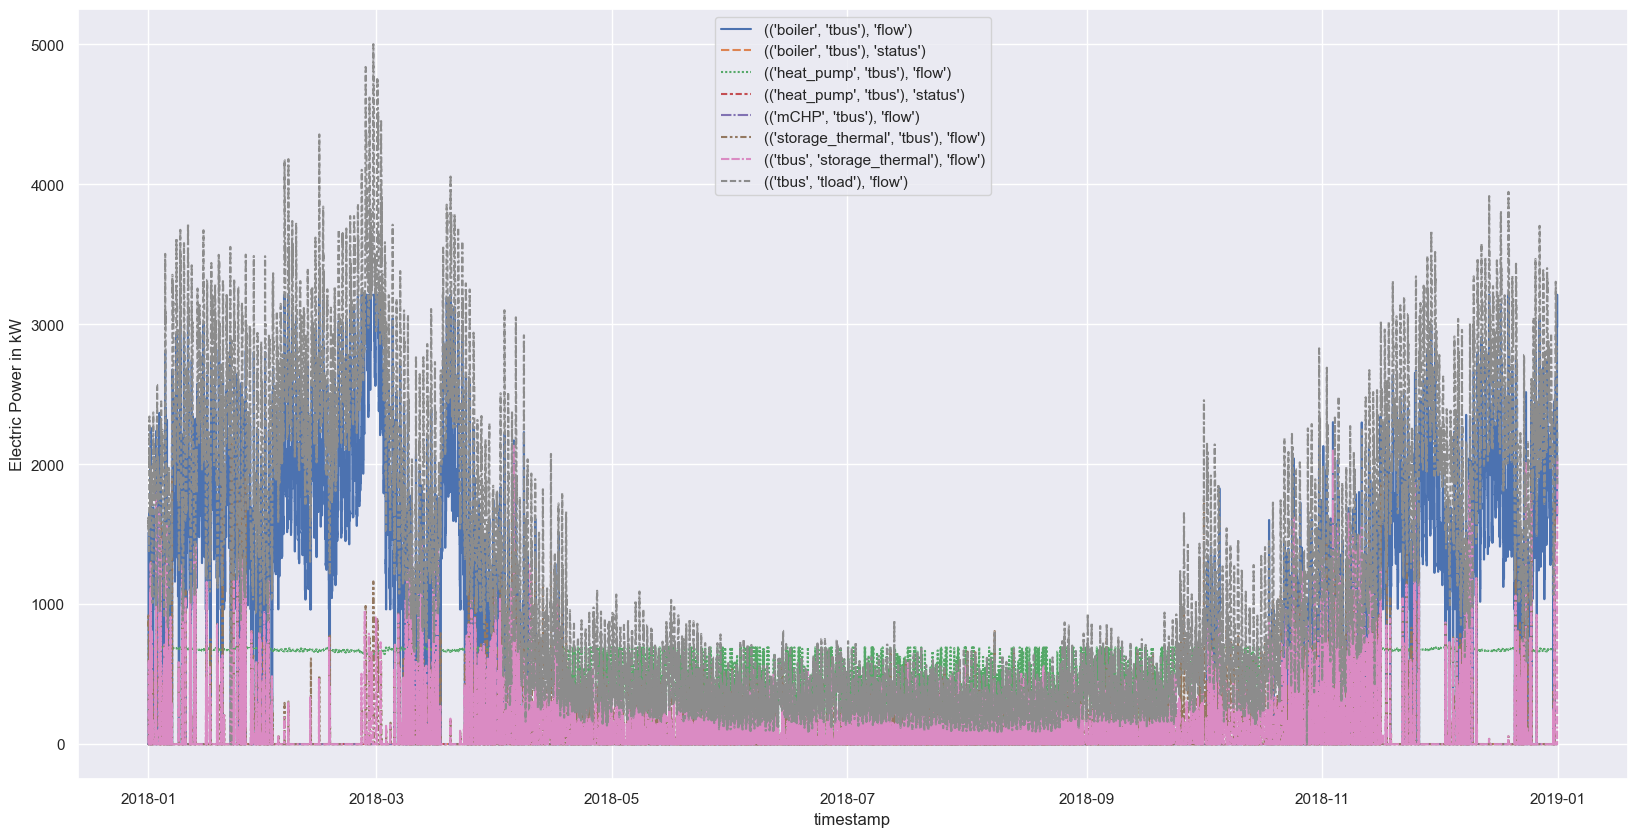

In [32]:
plt.figure(figsize=(20,10))
profiles = solph.processing.results(om)
res_bth = solph.views.node(profiles,'tbus')['sequences']
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bth, drawstyle='steps-post')
plot.set(ylabel='Electric Power in kW')

[Text(0, 0.5, 'Electric Power in kW')]

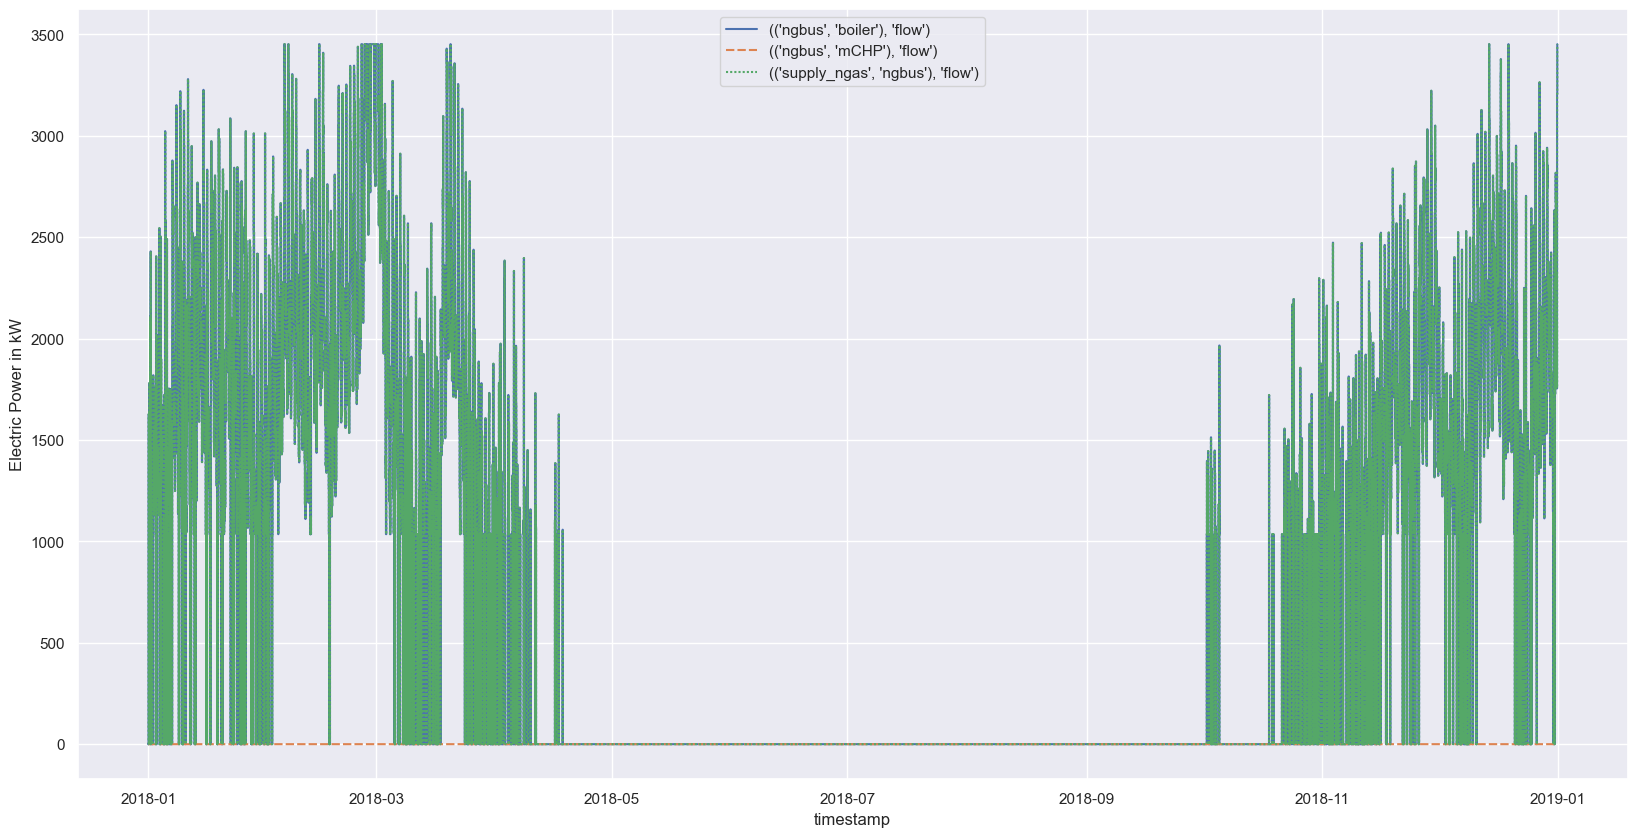

In [33]:
plt.figure(figsize=(20,10))
profiles = solph.processing.results(om)
res_bngas = solph.views.node(profiles,'ngbus')['sequences']
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bngas, drawstyle='steps-post')
plot.set(ylabel='Electric Power in kW')

[Text(0, 0.5, ' Power in kW')]

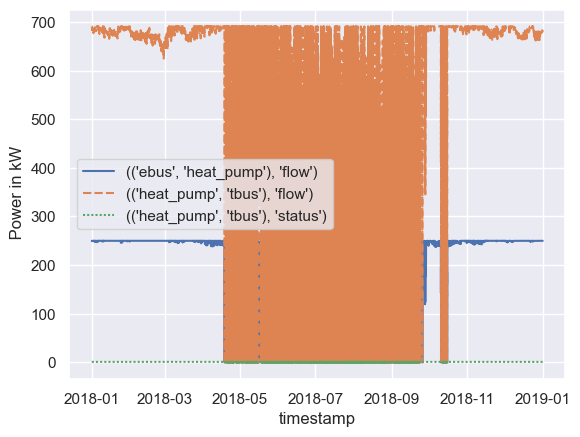

In [34]:
plot = sns.lineplot(data=res_hp, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')

[Text(0, 0.5, ' Power in kW')]

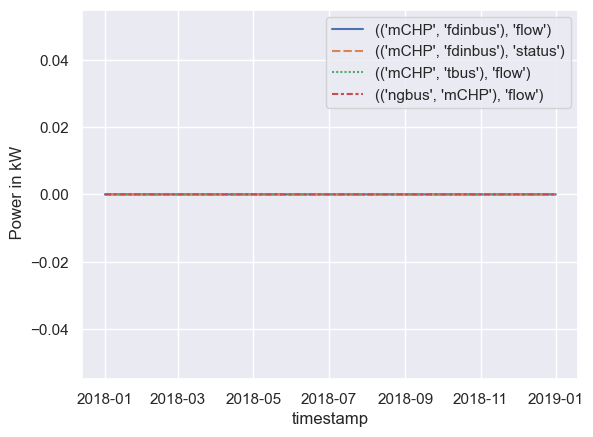

In [35]:
plot = sns.lineplot(data=res_chp, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')

[Text(0, 0.5, ' Power in kW')]

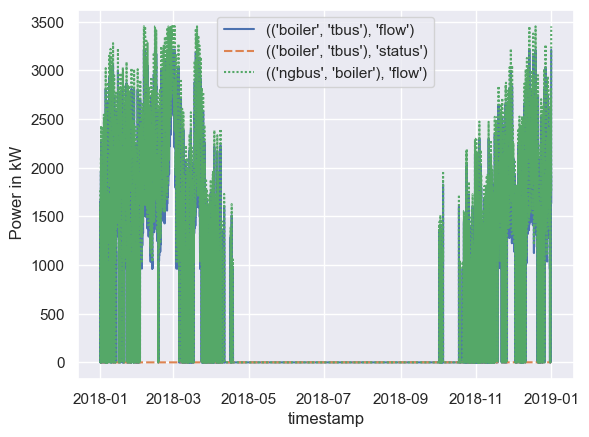

In [36]:
plot = sns.lineplot(data=res_boiler, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')

[Text(0, 0.5, ' Power in kW')]

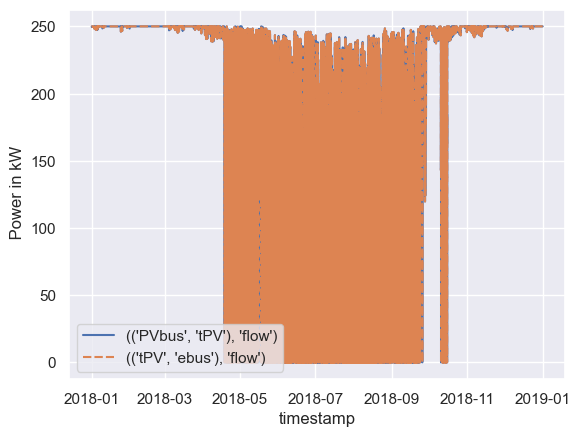

In [37]:
plot = sns.lineplot(data=res_pv, drawstyle='steps-post')
plot.set(ylabel=' Power in kW')